<a href="https://colab.research.google.com/github/wileyloyd/wileyloyd.github.io/blob/main/Medical_ARIMA_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of Medical Revenue Data

# Install missing packages after restart

In [1]:
# !pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00


# Load the packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.api import graphics
from math import sqrt
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')

# Connect to Google Drive and load CSV

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# medical = pd.read_csv("/Users/wileyloyd/Library/CloudStorage/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Medical Time Series Analysis/medical_time_series .csv", index_col = "Day", parse_dates=True)
medical = pd.read_csv('/content/drive/My Drive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Medical Time Series Analysis/medical_time_series.csv', index_col = "Day", parse_dates = True)

# Initial analysis

## Initial assessment of data

In [5]:
medical.shape

(731, 1)

In [6]:
medical.isnull().any()

Revenue    False
dtype: bool

Text(0.5, 1.0, 'Medical Revenue Data')

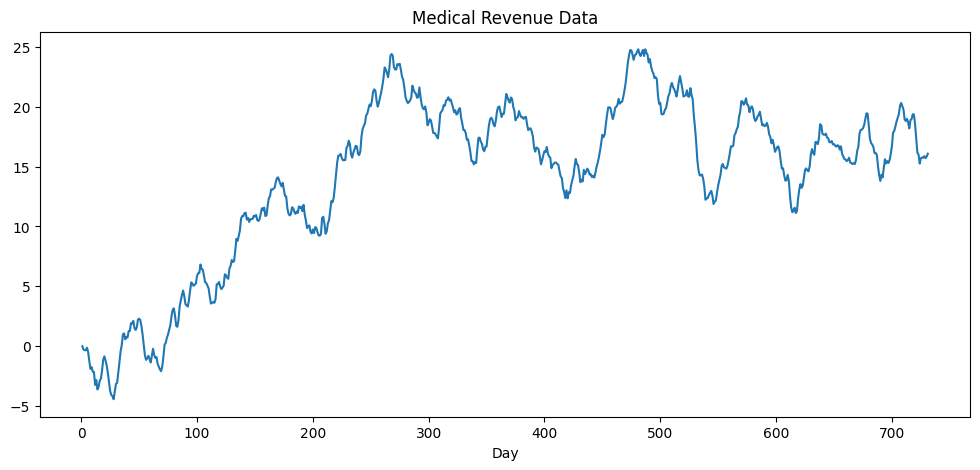

In [7]:
medical["Revenue"].plot(figsize=(12,5))
plt.title("Medical Revenue Data")

In [8]:
print("Index Length: ", len(medical.index))

print("Maximum Index Value: ", medical.index.max())

print("Missing Index Count: ", medical.index.max() - len(medical.index))

print("Distinct Index Counts: ", medical.index.value_counts().max())

Index Length:  731
Maximum Index Value:  731
Missing Index Count:  0
Distinct Index Counts:  1


In [9]:
rolling_mean = medical["Revenue"].rolling(window=30, center=True).mean()

rolling_std = medical['Revenue'].rolling(window=30, center=True).std()

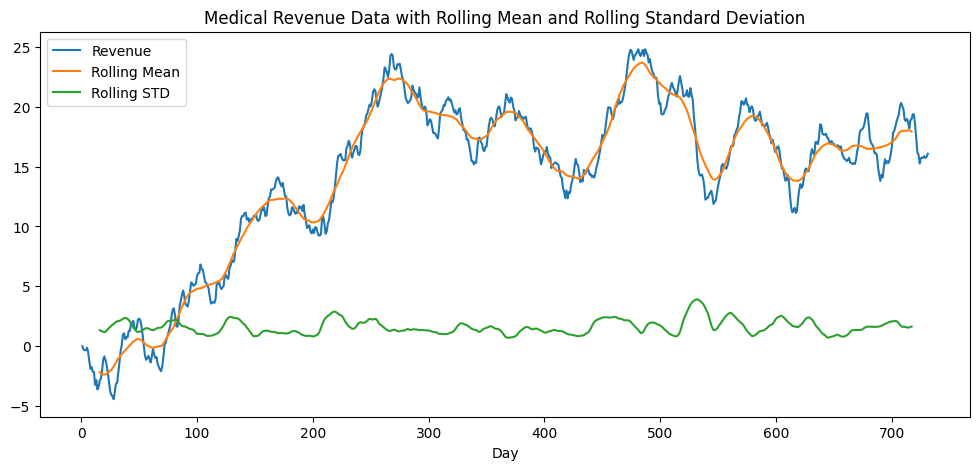

In [10]:
medical["Revenue"].plot(figsize=(12,5))
rolling_mean.plot()
rolling_std.plot()
plt.legend(['Revenue', 'Rolling Mean', 'Rolling STD'])
plt.title("Medical Revenue Data with Rolling Mean and Rolling Standard Deviation")
plt.show()

## Preparing the Data for Seasonal Decomposition

The data will need to be shifted up above 0 for the multiplicative model to work. Taking the absolute value of the minimum value of the revenue plus one will allow the model to run.

In [11]:
rev_shift = abs(medical['Revenue'].min()) + 1
medical_revenue = medical['Revenue'] + rev_shift

## Seasonal Decomposition

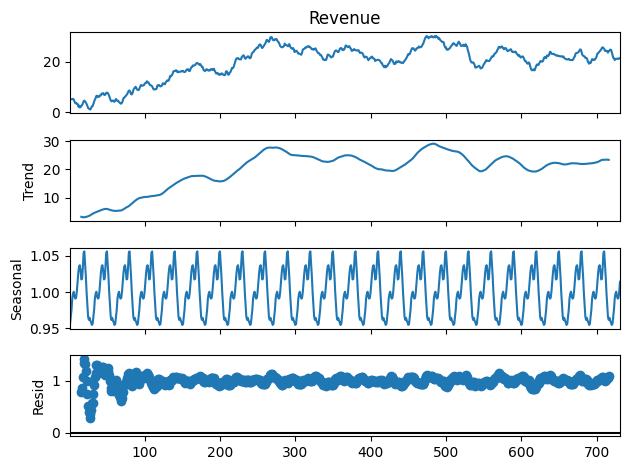

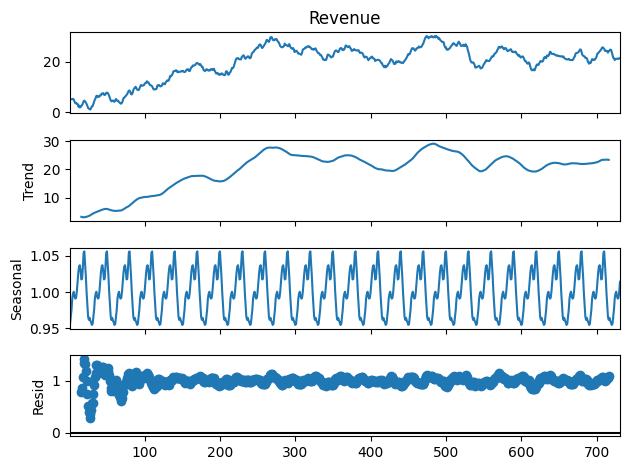

In [12]:
seasonal_decompose(medical_revenue, model='multiplicative', period=30).plot()

# Differencing the data

The best differencing is 1.

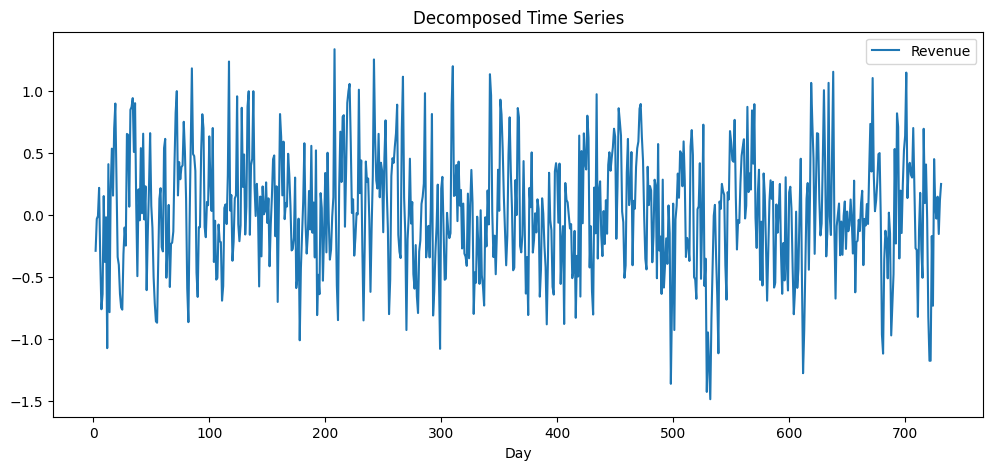

In [13]:
medical_diff = pd.DataFrame.diff(medical)
medical_diff = medical_diff.dropna()
medical_diff.plot(figsize=(12,5))
plt.title('Decomposed Time Series')
plt.show()

## Spectral Density

Spectral density is used to identify seasonality present in the data. A flat line tell you the data does not have seasonality.

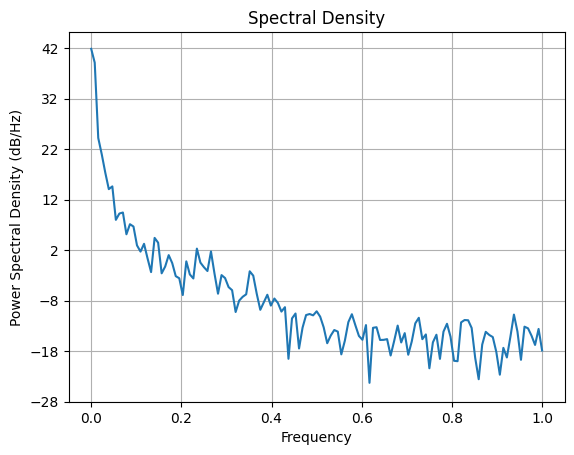

In [14]:
plt.psd(medical['Revenue'])
plt.title('Spectral Density')
plt.show()

This visualization of spectral density indicates the data does have seasonality.

## Exporting data to CSV

In [15]:
medical_diff.to_csv('/content/drive/My Drive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Medical Time Series Analysis/medical_time_series_cleaned.csv')

## Augmented Dickey-Fuller Test
According to the p-value, the data is NOT stationary, thus this analysis will require the data to be made stationary.

It's worth noting that the direction of the plot of the data having a positive increase would support the high p-value.

The absolute value of the critical values is greater than the absolute value of the ADF statistic, which is another indicator that the dataset will need to be transformed to be stationary.



In [16]:
# code from "https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=551c3203-d37e-4adb-8639-aed60102ce05" : 14:46
def adf(data):
    dftest = adfuller(medical, autolag = 'AIC')
    print("ADF: ", dftest[0])
    print("p-value: ", dftest[1])
    print("Number of Lags: ", dftest[2])
    print("Number of Observations Used: ", dftest[3])
    print("Critical Values: ", dftest[4])
    for key, val in dftest[4].items():
        print("/t", key, ": ", val)


In [17]:
adf(medical)

ADF:  -2.218319047608945
p-value:  0.19966400615064372
Number of Lags:  1
Number of Observations Used:  729
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
/t 1% :  -3.4393520240470554
/t 5% :  -2.8655128165959236
/t 10% :  -2.5688855736949163


# Manually Finding ARIMA Parameter Values

In [18]:
# RSS Calculation Function
def rss(model, data):
   x = sum((model.fittedvalues - data) ** 2)
   return(x)

In [ ]:
# MODEL 1
arima1 = ARIMA(medical['Revenue'], order=(31,1, 31)).fit()
print('RSS: ', rss(arima1, medical['Revenue']), '\n', 'AIC: ', arima1.aic)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(medical['Revenue'], label='Revenue', color = 'orange')
plt.plot(arima1.resid, label='Residuals', color = 'red')
plt.title('Medical Revenue Data compared to ARIMA1 Model Residuals')
plt.legend()
plt.show()

In [ ]:
prediction = arima1.get_prediction(start = len(medical), end = len(medical) + 100)
predicted_values = prediction.predicted_mean
ci = prediction.conf_int()

plt.figure(figsize=(12,5))
plt.plot(medical['Revenue'], label='Revenue', color = 'blue')
plt.plot(arima1.fittedvalues,label='Fitted Values', color = 'orange')
plt.plot(predicted_values, label='Predicted Values', color = 'red')
plt.fill_between(predicted_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color="black", alpha=0.05, label="Prediction Interval")
plt.title('ARIMA[31,1,31] RSS: %.4f'% rss(arima1, medical['Revenue']))
plt.legend()
plt.show()

In [ ]:
graphics.tsa.plot_acf(arima1.resid, lags=31)
plt.title("Autocorrelation Function (ACF) - ARIMA1 - Lag 31")
plt.show()

In [ ]:
# MODEL 2
arima2 = ARIMA(medical['Revenue'], order = (30,1,30)).fit()
print('RSS: ', rss(arima2, medical['Revenue']), '\n', 'AIC: ', arima2.aic)

In [ ]:
graphics.tsa.plot_acf(arima2.resid, lags=30)
plt.title("Autocorrelation Function (ACF) - ARIMA2 - Lag 30")
plt.show()

In [ ]:
# MODEL 3
arima3 = ARIMA(medical['Revenue'], order = (28,1,28)).fit()
print('RSS: ', rss(arima3, medical['Revenue']), '\n', 'AIC: ', arima3.aic)

In [ ]:
graphics.tsa.plot_acf(arima3.resid, lags=28)
plt.title("Autocorrelation Function (ACF) - ARIMA3 - Lag 28")
plt.show()

In [ ]:
# MODEL 4
arima4 = ARIMA(medical['Revenue'], order = (31,2,31)).fit()
print('RSS: ', rss(arima4, medical['Revenue']), '\n', 'AIC: ', arima4.aic)

In [ ]:
graphics.tsa.plot_acf(arima4.resid, lags=31)
plt.title("Autocorrelation Function (ACF) - ARIMA4 - Lag 31")
plt.show()

In [ ]:
# MODEL 5
arima5 = ARIMA(medical['Revenue'], order = (30,2,30)).fit()
print('RSS: ', rss(arima5, medical['Revenue']), '\n', 'AIC: ', arima5.aic)

In [ ]:
graphics.tsa.plot_acf(arima5.resid, lags=30)
plt.title("Autocorrelation Function (ACF) - ARIMA5 - Lag 30")
plt.show()

In [ ]:
# MODEL 6
arima6 = ARIMA(medical['Revenue'], order = (28,2,28)).fit()
print('RSS: ', rss(arima6, medical['Revenue']), '\n', 'AIC: ', arima6.aic)

In [ ]:
graphics.tsa.plot_acf(arima6.resid, lags=28)
plt.title("Autocorrelation Function (ACF) - ARIMA6 - Lag 28")
plt.show()

In [ ]:
# MODEL 7
arima7 = ARIMA(medical['Revenue'], order = (31,1,31)).fit()
print('RSS: ', rss(arima7, medical['Revenue']), '\n', 'AIC: ', arima7.aic)

In [ ]:
graphics.tsa.plot_acf(arima7.resid, lags=31)
plt.title("Autocorrelation Function (ACF) - ARIMA7 - Lag 31")
plt.show()

Manually trying to identify the optimal pdq metrics for the ARIMA model can be a difficult task. The following section of code works to use for loops to cycle through pdq score combinations to find the best model.

# Finding the Best ARIMA Model Using Akaike Information Criterion (AIC)

This section tests every combination of p,d,q values between 28 and 31 to identify the best performing model metrics.

In [ ]:
train = medical.iloc[:-30]
test = medical.iloc[-30:]
print(train.shape, test.shape)

In [ ]:
# Define the range of values for p, d, and q
# p_values = range(0, 5)
p_values = range(28, 32)
d_values = [1]
q_values = range(28, 32)

best_aic = float("inf")  # Initialize AIC with a high value

# Loop through different combinations of p, q, and d
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train['Revenue'], order=(p, d, q)).fit()

                # Calculate the AIC (Akaike Information Criterion)
                aic = model.aic

                # Update the best model if the AIC is lower
                if aic < best_aic:
                    best_aic = aic
                    best_model_aic = model
                    best_p, best_d, best_q = p, d, q

            except Exception as e:
                pass  # Skip models that cannot be fitted

# Print the best model's order (p, d, q)
print("Best ARIMA Model Order (p, d, q):", best_p, best_d, best_q)
print("Best AIC: ", best_aic)
print('RSS: ', rss(best_model_aic, train['Revenue']))

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(medical['Revenue'], label='Revenue', color = 'orange')
plt.plot(best_model_aic.fittedvalues, label='Fitted Values', color = 'red')
plt.legend()
plt.title('RSS: %.4f'% rss(best_model_aic, train['Revenue']))

In [ ]:
plt.plot(best_model_aic.resid)
plt.title('Best ARIMA Model Residuals Using AIC')
plt.show()

In [ ]:
graphics.tsa.plot_acf(best_model_aic.resid, lags=best_p)
plt.title("Autocorrelation Function (ACF)")
plt.show()

In [ ]:
graphics.tsa.plot_pacf(best_model_aic.resid, lags=best_p)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
# prediction = arima_best_model.predict(start = 731, end = 800, typ="levels")
prediction = best_model_aic.get_prediction(start = len(medical), end = len(medical) + 100)


ci = prediction.conf_int()
predicted_values = prediction.predicted_mean


plt.figure(figsize=(12,6))
plt.plot(medical.iloc[:-30], label='Revenue Train', color='blue')
plt.plot(medical.iloc[-30:],label='Revenue Test', color='orange')
plt.plot(predicted_values, label='Forecast', color='red')
plt.fill_between(predicted_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color="black", alpha=0.05, label="Prediction Interval")
plt.legend()
plt.title('Revenue Prediction')
plt.show()

The model selected with the lowest AIC predict poorly.

In [ ]:
predicted_values.head()

In [ ]:
predicted_values.tail()

In [ ]:
rmse = sqrt(mse(predicted_values[-30:], test['Revenue']))
print('Root Mean Squared Error: ', rmse)

# Finding the best ARIMA model Using Residual Sum of Squares (RSS)

In [ ]:
# Define the range of values for p, d, and q
p_values = range(28, 32)
d_values = [1]
q_values = range(28, 32)

best_rss = float("inf")  # Initialize RSS with a high value

# Loop through different combinations of p, q, and d
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train['Revenue'], order=(p, d, q)).fit()

                # Calculate the RSS (Residual Sum of Squares)
                current_rss = rss(model, train['Revenue'])

                # Update the best model if the RSS is lower
                if current_rss < best_rss:
                    best_rss = current_rss
                    best_model_rss = model
                    best_p, best_d, best_q = p, d, q

            except Exception as e:
                pass  # Skip models that cannot be fitted

# Print the best model's order (p, d, q)
print("Best ARIMA Model Order (p, d, q):", best_p, best_d, best_q)
print("Best RSS: ", best_rss)

In [ ]:
print("Best ARIMA Model Order (p, d, q):", best_p, best_d, best_q)
print("Best AIC: ", best_model_rss.aic)
print('RSS: ', rss(best_model_rss, train['Revenue']))

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(medical['Revenue'], label='Revenue', color = 'orange')
plt.plot(best_model_rss.fittedvalues, label='Fitted Values', color = 'red')
plt.title('RSS: %.4f'% rss(best_model_rss, train['Revenue']))
plt.legend()
plt.show()

In [ ]:
plt.plot(best_model_rss.resid)
plt.title('Best ARIMA Model Residuals Using RSS')
plt.show()

In [ ]:
graphics.tsa.plot_acf(best_model_rss.resid, lags=best_p)
plt.title("Autocorrelation Function (ACF)")
plt.show()

In [ ]:
graphics.tsa.plot_pacf(best_model_rss.resid, lags=best_p)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
prediction = best_model_rss.get_prediction(start = len(medical), end = len(medical) + 100)


ci = prediction.conf_int()
predicted_values = prediction.predicted_mean


plt.figure(figsize=(12,6))
plt.plot(medical.iloc[:-30], label='Revenue Train', color='blue')
plt.plot(medical.iloc[-30:],label='Revenue Test', color='orange')
plt.plot(predicted_values, label='Forecast', color='red')
plt.fill_between(predicted_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color="black", alpha=0.05, label="Prediction Interval")
plt.legend()
plt.title('Revenue Prediction')
plt.show()

# AUTO ARIMA
The first set of parentheses provides the p,d,q for the model, and the second set of parentheses indicates the seasonaity of the data.

The SARIMAX is a seasonal ARIMA model that is more robust. This will run even if there is no seasonality in the data.

In [ ]:
stepwise_fit = auto_arima(train["Revenue"], trace = True, suppress_warnings=True)
stepwise_fit.summary()

In [ ]:
auto_arima_model = stepwise_fit.predict_in_sample()
print(auto_arima_model)

In [ ]:
auto_model = ARIMA(train["Revenue"], order=(1,1,0))
auto_model = auto_model.fit()
auto_model.summary()
print('AIC: ', auto_model.aic,'\n', 'RSS: ', rss(auto_model, train['Revenue']))

In [ ]:
plt.plot(auto_model.resid)
plt.title('Auto ARIMA Model Residuals')
plt.show()

In [ ]:
graphics.tsa.plot_acf(auto_model.resid, lags=best_p)
plt.title("Auto ARIMA Autocorrelation Function (ACF)")
plt.show()

In [ ]:
graphics.tsa.plot_pacf(auto_model.resid, lags=best_p)
plt.title("Auto ARIMA Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
prediction = model.get_prediction(start = len(medical), end = len(medical) + 100)


ci = prediction.conf_int()
predicted_values = prediction.predicted_mean


plt.figure(figsize=(12,6))
plt.plot(medical.iloc[:-30], label='Revenue Train', color='blue')
plt.plot(medical.iloc[-30:],label='Revenue Test', color='orange')
plt.plot(predicted_values, label='Forecast', color='red')
plt.fill_between(predicted_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color="black", alpha=0.05, label="Prediction Interval")
plt.legend(loc='upper left')
plt.title('Auto ARIMA Revenue Prediction')
plt.show()

In [ ]:
rmse = sqrt(mse(predicted_values[-30:], test['Revenue']))
print('Root Mean Squared Error: ', rmse)